In [1]:
import rebound
import numpy as np
from scipy.interpolate import interp2d, interp1d
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from astropy import time
import pandas as pd


%matplotlib notebook

In [2]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":10,
                                "axes.titlesize":10,
                                "axes.labelsize":10})
sns.set_palette("colorblind", color_codes=True)



In [2]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

# For dark background plots 
sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'white',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'white',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'black',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'white',
 'xtick.bottom': True,
 'xtick.color': 'white',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'white',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":14,
                                "axes.labelsize":14})
sns.set_palette("colorblind", color_codes=True)


In [3]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = time.Time(2023, format='decimalyear').mjd   # t_ref = T0_AB 

e_B = 0.805
i_B = -np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)+np.pi/2
T0_B = 48707.5
P_B = 314.86
mean_B = (2*np.pi*((t_ref - T0_B)/P_B))%(2*np.pi)

e_A = 0.4808
i_A = -np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)+np.pi/2
T0_A = 48742.5
P_A = 264.51
mean_A = (2*np.pi*((t_ref - T0_A)/P_A))%(2*np.pi)

e_AB = 0.46
i_AB = -np.radians(88.1)
a_AB = 51
m_A = 1.22
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)+np.pi/2
T0_AB = 2023
P_AB = 230
mean_AB = 0.0


# Disc parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disc = 0.03
pos_disc = np.radians(15.6)+np.pi/2
inc_disc = np.radians(26)
omega_disc = np.radians(-73)


In [4]:
def convmf(m_in, e_in):
    """Convert array of mean to true anomaly (for single e).
        
    From Vallado
    
    .. todo: tidy and include other orbit cases
    """
    
    m = np.array(m_in % (2. * np.pi))
    numiter = 50
    small = 0.00000001
    if e_in > small:
        
        ecc = np.array(e_in * 1.0)
        
        #       ;; /* ------------  initial guess ------------- */
        e0 = np.array(m + ecc)
        lo = np.logical_or( (m < 0.0) & (m > -np.pi), m > np.pi)
        e0[lo] = m[lo] - ecc
        
        ktr = 1
        e1  = np.array(e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0)))
        while (np.max(np.abs(e1 - e0)) > small) & (ktr <= numiter):
            ktr += 1
            do = np.abs(e1 - e0) > small
            e0[do] = e1[do]
            e1[do] = e0[do] + (m[do] - e0[do] + ecc * np.sin(e0[do])) / (1.0 - ecc * np.cos(e0[do]))
        
        #       ;; /* ---------  find true anomaly  ----------- */
        sinv = (np.sqrt(1.0 - ecc * ecc) * np.sin(e1)) / (1.0-ecc * np.cos(e1))
        cosv = (np.cos(e1) - ecc) / (1.0 - ecc * np.cos(e1))
        nu   = np.arctan2( sinv, cosv)
    
    else:
        #       ;; /* --------------------- circular --------------------- */
        ktr = 0
        nu  = m
        e0  = m

    if ktr > numiter:
        print('WARNING: convmf did not converge')
    
    return nu

def convfm(f_in, ecc):
    '''Convert true to mean anomaly.
    
    Parameters
    ----------
    f_in : float or ndarray
        True anomaly.
    ecc : float or ndarray
        Eccentricity
    '''
    tf2 = np.tan(0.5*f_in)
    fact = np.sqrt( (1.0+ecc) / (1.0-ecc) )
    bige = 2 * np.arctan2(tf2, fact)
    bigm = bige - ecc * np.sin(bige)
    
    return bigm

anom_A = convmf(mean_A, e_A)
anom_B = convmf(mean_B, e_B)
anom_AB  = convmf(mean_AB, e_AB)



In [5]:
def fill_disc(inner_r, outer_r, ang, axis, colour='k', alpha=0.5, ec=None):
    a, b = [inner_r, outer_r], [inner_r*np.cos(inc_disc)*(1-e_disc**2)**0.5, 
                                outer_r*np.cos(inc_disc)*(1-e_disc**2)**0.5]
    
    x = np.outer(a, np.cos(ang))
    y = np.outer(b, np.sin(ang))
    xs = x*np.cos(pos_disc) - y*np.sin(pos_disc)
    ys = x*np.sin(pos_disc) + y*np.cos(pos_disc)
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    axis.fill(np.ravel(xs), np.ravel(ys), color=colour, edgecolor=ec, alpha=alpha)

def merge_ev_files(sink, wd='./data', ev_files=1):
    data = pd.DataFrame()
    for file_number in range(1, ev_files+1):
        data_subset = pd.read_csv(
        f'{wd}/discSink000{sink}N0{file_number}.ev', sep='\s+', skiprows=[0], engine='python', names=[str(i) for i in range(20)]
    )
        data = pd.concat([data, data_subset], ignore_index=True)
    
    return data


In [6]:
print(np.degrees(anom_A), anom_A)
print(np.degrees(anom_B), anom_B)
print(np.degrees(anom_AB), anom_AB)
print(mean_A,  mean_B, mean_AB)


157.706322184098 2.752494573323485
-166.60030265538973 -2.9077238161556025
2.903104364469517e-31 5.066872968901056e-33
2.2110275165108106 4.338323336660231 0.0


In [7]:
# Create system B (Ba + Bb)

sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Msun')


Ba = rebound.Particle(simulation=sim,
                      m=m_Ba,
                     )


Bb = rebound.Particle(simulation=sim,
                      primary=Ba,
                      m=m_Bb,
                      a=a_B,
                      e=e_B,
                      omega=omega_Bb,
                      inc=i_B,
                      Omega=Omega_B,
                      f=anom_B
                     )


sim.add(Ba)
sim.add(Bb)
sim.move_to_com()
Ba, Bb = sim.particles

sim_AB = rebound.Simulation()
sim_AB.units = ('days', 'AU', 'Msun')


B = rebound.Particle(simulation=sim_AB,
                      m=m_B,
                     )

sim_AB.add(B)

# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim_AB,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB,
                     f=anom_AB
                    )

sim_AB.add(A)

# Create system AaAb and shift to CoM reference frame

sim_A = rebound.Simulation()
sim_A.units = ('days', 'AU', 'Msun')


Ab = rebound.Particle(simulation=sim_A,
                      m=m_Ab,
                     )

Aa = rebound.Particle(simulation=sim_A,
                      primary=Ab,
                      m=m_Aa,
                      a=a_A,
                      e=e_A,
                      omega=omega_Aa,
                      inc=i_A,
                      Omega=Omega_A,
                      f=anom_A
                     )


sim_A.add(Aa)
sim_A.add(Ab)
sim_A.move_to_com()
Aa_A, Ab_A = sim_A.particles      # Aa and Ab in the A CoM reference frame


# Shift Aa and Ab into the system B CoM reference frame

def change_reference_frames(star, ref):
    # ref = old reference frame in the new reference frame
    # star = star in the old reference frame
    ref_v = np.array([ref.vx, ref.vy, ref.vz])                            # velocity of current reference frame in the new reference frame
    v_in_ref = np.array([star.vx, star.vy, star.vz])                      # velocity of star in current reference frame
    v = v_in_ref + ref_v                                                  # velocity of star in the new reference frame
    
    ref_pos = np.array([ref.x, ref.y, ref.z])                             # position of current reference frame in the new reference frame
    pos_in_ref = np.array([star.x, star.y, star.z])                       # position of star in current reference frame
    pos = pos_in_ref + ref_pos                                            # position of star in the new reference frame
    
    return pos,v

pos_Aa, v_Aa = change_reference_frames(Aa_A, A)
pos_Ab, v_Ab = change_reference_frames(Ab_A, A)

def generate_cartesian_particle(m, pos, v):
    x, y, z = pos
    vx, vy, vz = v
    return rebound.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)

Aa = generate_cartesian_particle(m_Aa, pos_Aa, v_Aa)
Ab = generate_cartesian_particle(m_Ab, pos_Ab, v_Ab)

sim.add(Aa)
sim.add(Ab)




In [8]:
print("Original anomalies:")
print('A:  ', np.degrees(anom_A), anom_A)
print('B:  ', np.degrees(anom_B), anom_B)
print('AB: ', np.degrees(anom_AB), anom_AB)
print('========= At t = 0 ===========')
sim.integrate(0)
sim_A.integrate(0)
sim_AB.integrate(0)
Ba, Bb, Aa, Ab  = sim.particles
Aa_A, Ab_A = sim_A.particles
B, A = sim_AB.particles

print('f of Bb, Aa, Ab (primary=Ba) = ', Bb.f, Aa.f, Ab.f)
print('f of  Bb - 2 pi              =', Bb.f - 2*np.pi)
print('a of Aa, Ab, Bb (primary=Ba) = ', Aa.a, Ab.a, Bb.a)
print('f of Ab     (primary=Aa)     = ', Ab_A.f)
print('f of AB     (primary=B)      = ', A.f)
print('==============================')
print('B:  ', np.degrees(Bb.f), Bb.f)
print('A:  ', np.degrees(Ab_A.f), Ab_A.f)
print('AB: ', np.degrees(A.f), A.f)
print('===== Mean anomalies ======')
print('Mean A:  ', convfm(Ab_A.f, e_A))
print('Mean B:  ', convfm(Bb.f, e_B))
print('Mean AB: ',  convfm(A.f, e_AB))

t_rewind = -12594.4       # 40 B orbits
print(f'====== At t = {t_rewind} =======')

sim.integrate(t_rewind)
sim_A.integrate(t_rewind)
sim_AB.integrate(t_rewind)
Ba, Bb, Aa, Ab  = sim.particles
Aa_A, Ab_A = sim_A.particles
B, A = sim_AB.particles

print('f of Bb, Aa, Ab (primary=Ba) = ', Bb.f, Aa.f, Ab.f)
print('a of Aa, Ab, Bb (primary=Ba) = ', Aa.a, Ab.a, Bb.a)
print('f of Ab     (primary=Aa)     = ', Ab_A.f)
print('f of AB     (primary=B)      = ', A.f)
print('==============================')
print('B:  ', np.degrees(Bb.f), Bb.f)
print('A:  ', np.degrees(Ab_A.f), Ab_A.f)
print('AB: ', np.degrees(A.f), A.f)

print('===== Mean anomalies ======')
print('Mean A:  ', convfm(Ab_A.f, e_A))
print('Mean B:  ', convfm(Bb.f, e_B))
print('Mean AB: ',  convfm(A.f, e_AB))

print('========  My values =======')
mean_A2 = -2*np.pi*((314.86*40/P_A)%1) + mean_A
mean_B2 = -2*np.pi*((314.86*40/P_B)%1) + mean_B
mean_AB2 = -2*np.pi*((314.86*40/(P_AB*365.25))%1) + mean_AB

print('Mean A:  ', convmf(mean_A2, e_A))
print('Mean B:  ', convmf(mean_B2, e_B))
print('Mean AB: ', convmf(mean_AB2, e_AB))

t_rewind = -420000          # ~5 AB orbits 
print(f'====== At t = {t_rewind} =======')

sim.integrate(t_rewind)
sim_A.integrate(t_rewind)
sim_AB.integrate(t_rewind)
Ba, Bb, Aa, Ab  = sim.particles
Aa_A, Ab_A = sim_A.particles
B, A = sim_AB.particles

print('f of Bb, Aa, Ab (primary=Ba) = ', Bb.f, Aa.f, Ab.f)
print('a of Aa, Ab, Bb (primary=Ba) = ', Aa.a, Ab.a, Bb.a)
print('f of Ab     (primary=Aa)     = ', Ab_A.f)
print('f of AB     (primary=B)      = ', A.f)
print('==============================')
print('B:  ', np.degrees(Bb.f), Bb.f)
print('A:  ', np.degrees(Ab_A.f), Ab_A.f)
print('AB: ', np.degrees(A.f), A.f)

print('===== Mean anomalies ======')
print('Mean A:  ', convfm(Ab_A.f, e_A))
print('Mean B:  ', convfm(Bb.f, e_B))
print('Mean AB: ',  convfm(A.f, e_AB))

print('========  My values =======')
mean_A2 = -2*np.pi*((314.86*40/P_A)%1) + mean_A
mean_B2 = -2*np.pi*((314.86*40/P_B)%1) + mean_B
mean_AB2 = -2*np.pi*((314.86*40/(P_AB*365.25))%1) + mean_AB

print('Mean A:  ', convmf(mean_A2, e_A))
print('Mean B:  ', convmf(mean_B2, e_B))
print('Mean AB: ', convmf(mean_AB2, e_AB))

Original anomalies:
A:   157.706322184098 2.752494573323485
B:   -166.60030265538973 -2.9077238161556025
AB:  2.903104364469517e-31 5.066872968901056e-33
========= At t = 0 ===========
f of Bb, Aa, Ab (primary=Ba) =  3.3754614910239837 3.5786934851198975 0.2822020903412401
f of  Bb - 2 pi              = -2.9077238161556025
a of Aa, Ab, Bb (primary=Ba) =  21.281614467602697 -5.725927747196782 1.0099999999999996
f of Ab     (primary=Aa)     =  2.7524945733234842
f of AB     (primary=B)      =  0.0
B:   193.39969734461027 3.3754614910239837
A:   157.70632218409796 2.7524945733234842
AB:  0.0 0.0
===== Mean anomalies ======
Mean A:   2.211027516510809
Mean B:   -1.9448619705193573
Mean AB:  0.0
====== At t = -12594.4 =======
f of Bb, Aa, Ab (primary=Ba) =  3.301380088901008 0.005025136288543841 4.911598522418545
a of Aa, Ab, Bb (primary=Ba) =  -111.08338103491 -14.410636074438683 1.009932507836097
f of Ab     (primary=Aa)     =  3.391828885519698
f of AB     (primary=B)      =  4.375590787

In [9]:
t = 0
sim.integrate(t)
sim_A.integrate(t)
sim_AB.integrate(t)
Ba, Bb, Aa, Ab  = sim.particles
Aa_A, Ab_A = sim_A.particles
B, A = sim_AB.particles

n_timesteps = 10000
timesteps = np.linspace(0,-12594.4, n_timesteps)

meanA1 = np.zeros(n_timesteps)
meanB1 = np.zeros(n_timesteps)
meanAB1 = np.zeros(n_timesteps)

meanA2 = np.zeros(n_timesteps)
meanB2 = np.zeros(n_timesteps)
meanAB2 = np.zeros(n_timesteps)

# fig_anoms, ax = plt.subplots(2, 1, figsize=(8,6))

for i, timestep in enumerate(timesteps):
    sim.integrate(timestep)
    sim_A.integrate(timestep)
    sim_AB.integrate(timestep)
    meanA1[i] = convfm(Ab_A.f, e_A)
    meanB1[i] = convfm(Bb.f, e_B)
    meanAB1[i] = convfm(A.f, e_AB)
    
    meanA2[i] =((2*np.pi*timestep/P_A)%1 + mean_A)%(2*np.pi)-np.pi
    meanB2[i] =((2*np.pi*timestep/P_B)%1 + mean_B)%(2*np.pi)-np.pi
    meanAB2[i] =((2*np.pi*timestep/(P_AB*365.25))%1 + mean_AB)%(2*np.pi)-np.pi

    

# ax[0].plot(timesteps, meanA1, 'r', label='A', figure=fig_anoms)
# ax[0].plot(timesteps, meanB1, 'b', label='B', figure=fig_anoms)
# ax[0].plot(timesteps, meanAB1, 'g', label='AB', figure=fig_anoms)
# ax[0].set_xlabel('Time (days)')
# ax[0].set_ylabel('Mean Anomaly')
# ax[0].legend()

# ax[1].plot(timesteps, meanA2, 'r', label='A', figure=fig_anoms)
# ax[1].plot(timesteps, meanB2, 'b', label='B', figure=fig_anoms)
# ax[1].plot(timesteps, meanAB2, 'g', label='AB', figure=fig_anoms)
# ax[1].set_xlabel('Time (days)')
# ax[1].set_ylabel('Mean Anomaly')
# ax[1].legend()

In [10]:
# Plot orbits

# start_time = -40*314.86    # - 40 B binary orbits
start_time = 0
# t_max = 18*365.25 + start_time   # integrate over 18 years
# t_max = 37780.32    #  12 B binary orbits  
t_max = 15*314.86
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_Aa, y_Aa, z_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Ab, y_Ab, z_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps) 
x_Ba, y_Ba, z_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Bb, y_Bb, z_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


vx_Aa, vy_Aa, vz_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ab, vy_Ab, vz_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ba, vy_Ba, vz_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Bb, vy_Bb, vz_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


Ba, Bb, Aa, Ab = sim.particles

for i, t in enumerate(times):
    sim.integrate(t)

    # Calculate the CoM of Ba and Bb
    comB = sim.calculate_com(first=0, last=2)     
    pos_comB = np.array([comB.x, comB.y, comB.z])
    comA = sim.calculate_com(first=2, last=4)     
    pos_comA = np.array([comA.x, comA.y, comA.z])
    v_comB = np.array([comB.vx, comB.vy, comB.vz])
    
    # Recenter all components so the CoM of BaBb is at the origin
    x_Ba[i], y_Ba[i], z_Ba[i] = np.array([Ba.x, Ba.y, Ba.z]) - pos_comB
    x_Bb[i], y_Bb[i], z_Bb[i] = np.array([Bb.x, Bb.y, Bb.z]) - pos_comB
    vx_Ba[i], vy_Ba[i], vz_Ba[i] = np.array([Ba.vx, Ba.vy, Ba.vz]) - v_comB
    vx_Bb[i], vy_Bb[i], vz_Bb[i] = np.array([Bb.vx, Bb.vy, Bb.vz]) - v_comB
    
    x_Aa[i], y_Aa[i], z_Aa[i] = np.array([Aa.x, Aa.y, Aa.z]) - pos_comB
    x_Ab[i], y_Ab[i], z_Ab[i] = np.array([Ab.x, Ab.y, Ab.z]) - pos_comB
    vx_Aa[i], vy_Aa[i], vz_Aa[i] = np.array([Aa.vx, Aa.vy, Aa.vz]) - v_comB
    vx_Ab[i], vy_Ab[i], vz_Ab[i] = np.array([Ab.vx, Ab.vy, Ab.vz]) - v_comB



In [ ]:
# from matplotlib.collections import LineCollection

# timestep=5000

# def get_color(color):
#     if isinstance(color, tuple) and len(color) == 3: # already a tuple of RGB values
#         return color

#     try:
#         import matplotlib.colors as mplcolors
#     except:
#         raise ImportError("Error importing matplotlib. If running from within a jupyter notebook, try calling '%matplotlib inline' beforehand.")
   
#     try:
#         hexcolor = mplcolors.cnames[color]
#     except KeyError:
#         raise AttributeError("Color not recognized in matplotlib.")

#     hexcolor = hexcolor.lstrip('#')
#     lv = len(hexcolor)
#     return tuple(int(hexcolor[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3)) # tuple of rgb values
    
    
# def fading_line(x, y, color='black', alpha=1, **kwargs):
#     Npts = len(x)
#     if len(y) != Npts:
#         raise AttributeError("x and y must have same dimension.")
    
#     color = get_color(color)
#     colors = np.zeros((Npts,4))
#     colors[:,0:3] = color
#     colors[:,3] = alpha*np.linspace(0,1,Npts)

#     segments = np.zeros((Npts-1,2,2))
#     segments[:,0,0] = x[:-1]
#     segments[:,0,1] = y[:-1]
#     segments[:,1,0] = x[1:]
#     segments[:,1,1] = y[1:]

#     lc = LineCollection(segments, color=colors, **kwargs)
#     return lc

# def OrbitPlot(star_positions, coms=[], labels=['Aa', 'Ab', 'Ba', 'Bb'], timestep=5000, figsize=(6,4), unitlabel='(AU)', color=False, lw=1., Narc=500):
#     fig, ax = plt.subplots(figsize=figsize, ncols=2)
#     ax_xy = ax[0]
#     ax_xy.set_xlabel("x "+unitlabel)
#     ax_xy.set_ylabel("y "+unitlabel)    
    
#     ax_xz = ax[1]
#     ax_xz.set_xlabel("x "+unitlabel)
#     ax_xz.set_ylabel("z "+unitlabel)
    
#     for i,star_pos in enumerate(star_positions):
#         label = labels[i]
#         x,y,z = star_pos            # all x,y,z positions for a single star
#         p_xy = ax_xy.plot(x[timestep],y[timestep], marker="*", label=label)
#         p_xz = ax_xz.plot(x[timestep],z[timestep], marker="*", label=label)
        
#         xy_trail = fading_line(x[timestep-Narc:timestep], y[timestep-Narc:timestep], color=p_xy[0].get_color())
#         xz_trail = fading_line(x[timestep-Narc:timestep], z[timestep-Narc:timestep], color=p_xz[0].get_color())   
#         ax_xy.add_collection(xy_trail)
#         ax_xz.add_collection(xz_trail)
#         ax_xz.legend()
        
# #     for com in coms:
# #         x_com,y_com,z_com = com[0,:], com[1,:], com[2,:]
# #         print(timestep, y_com[timestep])
# #         ax_xy.plot(x_com[timestep], y_com[timestep], marker='x', color='black')
# #         ax_xz.plot(x_com[timestep], z_com[timestep], marker='x', color='black')

# #         xycom_trail = fading_line(x_com[timestep-Narc:timestep], y_com[timestep-Narc:timestep], color=p_xy[0].get_color())
# #         xzcom_trail = fading_line(x_com[timestep-Narc:timestep], z_com[timestep-Narc:timestep], color=p_xz[0].get_color())   

       

# stars_pos = np.array([[x_Aa, y_Aa, z_Aa],[x_Ab, y_Ab, z_Ab], [x_Ba, y_Ba, z_Ba], [x_Bb, y_Bb, z_Bb]])
# OrbitPlot(stars_pos, coms=[comA_posarray, comB_posarray], timestep=timestep, Narc=700)



<IPython.core.display.Javascript object>


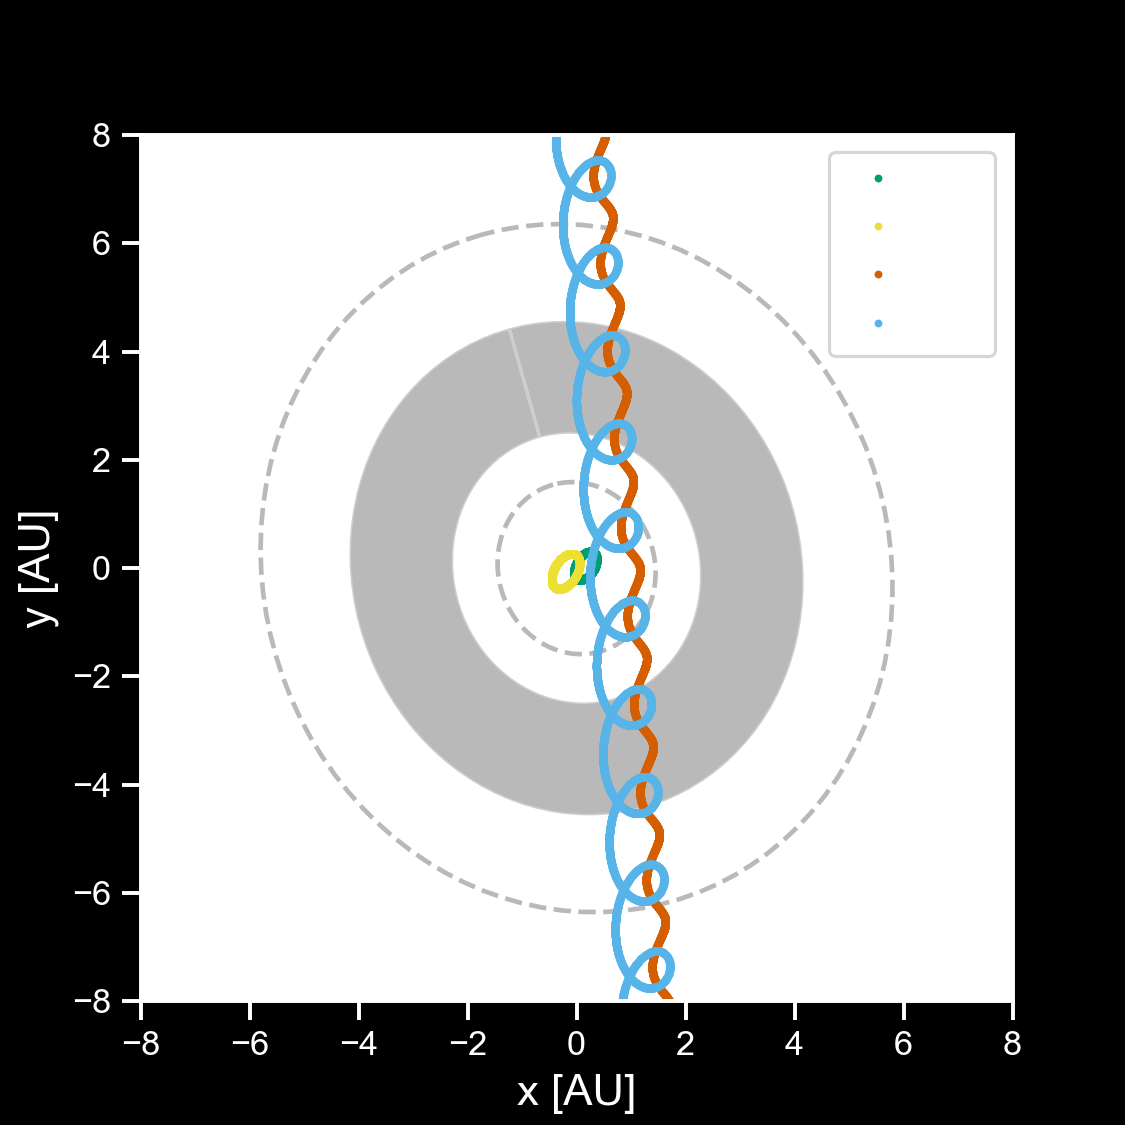

In [13]:
# Build disc
%matplotlib notebook

angles = np.linspace(0, 2*np.pi, 100)

def disc_edge(a, angles=angles):
    b = a*np.cos(inc_disc)*(1-e_disc**2)**0.5
    x = a*np.cos(angles)
    y = b*np.sin(angles)
    z = x*np.tan(inc_disc)

    return x*np.cos(pos_disc) - y*np.sin(pos_disc), x*np.sin(pos_disc) + y*np.cos(pos_disc), z

x_inner1, y_inner1, z_inner1 = disc_edge(a_inner)
x_outer1, y_outer1, z_outer1 = disc_edge(a_outer)

x_inner2, y_inner2, z_inner2 = disc_edge(1.6)
x_outer2, y_outer2, z_outer2 = disc_edge(6.4)


# Make 2D plot
fig,ax = plt.subplots(figsize=(5,5))

fill_disc(a_inner, a_outer, angles, ax, colour='k', alpha=0.3)
plt.plot(x_outer2, y_outer2, 'k--', alpha=0.3, figure=fig)
plt.plot(x_inner2, y_inner2, 'k--', alpha=0.3, figure=fig)

plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')

plt.plot(x_Ba, y_Ba, 'g.', alpha = 1, markersize=3, label='Ba', figure=fig)
plt.plot(x_Bb, y_Bb, 'y.', alpha = 1, markersize=3, label='Bb', figure=fig)
plt.plot(x_Aa, y_Aa, 'r.', alpha = 1, markersize=3, label='Aa', figure=fig)
plt.plot(x_Ab, y_Ab, 'c.', alpha = 1, markersize=3, label='Ab', figure=fig)
leg = plt.legend()

# # 3D Plot
# ax = fig.add_subplot(111, projection='3d')

# # Plot binary orbits relative to the  CoM of BaBb
# ax.plot(x_Aa[0], y_Aa[0], z_Aa[0], 'b*', alpha = 0.9, label='Aa', markersize=8)
# ax.plot(x_Ab[0], y_Ab[0], z_Ab[0], 'r*', alpha = 0.9, label='Ab', markersize=8)
# ax.plot(x_Ba[0], y_Ba[0], z_Ba[0], 'g*', alpha = 0.9, label='Ba', markersize=8)
# ax.plot(x_Bb[0], y_Bb[0], z_Bb[0], 'c*', alpha = 0.9, label='Bb', markersize=8)
# # Plot disc in 3D
# ax.plot(x_outer1, y_outer1, z_outer2, 'white', alpha=0.3)
# ax.plot(x_inner2, y_inner2, z_inner2, 'white', alpha=0.3)
# # ax.xaxis.pane.set_edgecolor('black')
# # ax.yaxis.pane.set_edgecolor('black')
# # ax.zaxis.pane.set_edgecolor('black')
# fig.set_facecolor('black')
# ax.set_facecolor('black') 
# ax.grid(False) 
# ax.w_xaxis.pane.fill = False
# ax.w_yaxis.pane.fill = False
# ax.w_zaxis.pane.fill = False
# ax.xaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='y', colors='white')
# ax.zaxis.label.set_color('white')
# ax.tick_params(axis='z', colors='white')
# # fig.patch.set_facecolor('black')


# ax.set_xlabel('x [AU]')
# ax.set_ylabel('y [AU]')
# ax.set_zlabel('z [AU]')
# ax.set_xlim(-10,10)
# ax.set_ylim(-15,10)
# # ax.set_zlim(-10,10)

# ax.legend()




<IPython.core.display.Javascript object>


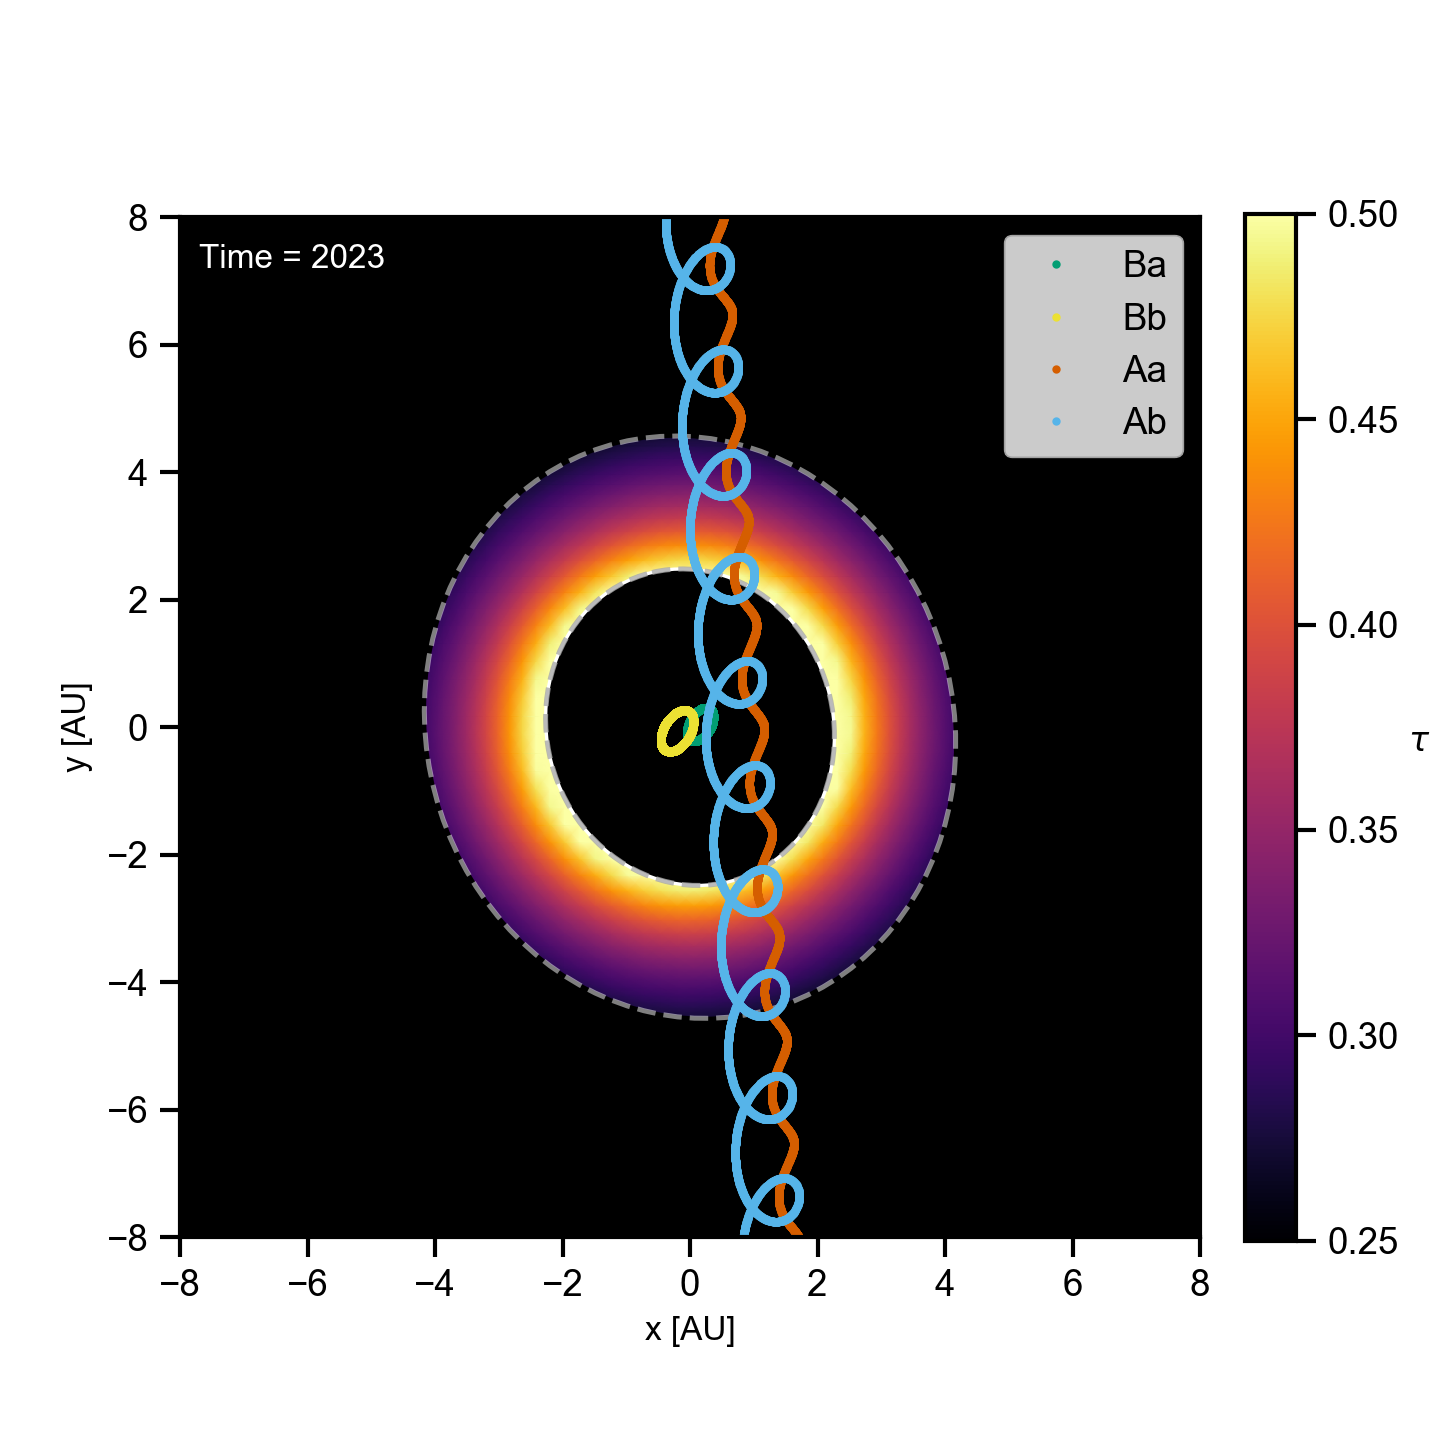

Text(-7.7, 7.2, 'Time = 2023')

In [20]:
# Build disc
%matplotlib notebook

inner_edge = 2.5
outer_edge = 4.6

x_inner1, y_inner1, z_inner1 = disc_edge(inner_edge)
x_outer1, y_outer1, z_outer1 = disc_edge(outer_edge)

fig,ax = plt.subplots(figsize=(6,6))

plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')

res = 10
xd = np.linspace(x_inner1, x_outer1, res)
yd = np.linspace(y_inner1, y_outer1, res)
X, Y = np.meshgrid(xd,yd)
r0 = inner_edge
R = (X**2 + Y**2)**0.5
taus = 0.5*(r0/R)
# print(X.shape, Y.shape, taus.shape)
# print(taus)

# taus[R > 4.6] = 0
# taus[R < 2.5] = 0

plt.fill(x_inner1,y_inner1, 'black')
fill_disc(outer_edge,20,np.linspace(0, 2*np.pi, 100), ax, colour='black', alpha=1, ec='black')
plt.plot(x_inner1, y_inner1, c='darkgrey', linestyle='dashed', alpha=0.8, figure=fig)
plt.plot(x_outer1, y_outer1, c='white', linestyle='dashed', alpha=0.5, figure=fig)

im = plt.pcolormesh(X, Y, taus, cmap='inferno', vmin=0.25, vmax=0.5, shading='gouraud')
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('$\\tau$', rotation=360, labelpad=6)
ax.set_aspect('equal')

plt.plot(x_Ba, y_Ba, 'g.', alpha = 1, markersize=3, label='Ba', figure=fig)
plt.plot(x_Bb, y_Bb, 'y.', alpha = 1, markersize=3, label='Bb', figure=fig)
plt.plot(x_Aa, y_Aa, 'r.', alpha = 1, markersize=3, label='Aa', figure=fig)
plt.plot(x_Ab, y_Ab, 'c.', alpha = 1, markersize=3, label='Ab', figure=fig)
leg = plt.legend()
leg.get_frame().set_facecolor('white')
year = 2023
# plt.text(-7.7, 7.2, f'Time = {year}', c='white')
# plt.setp(legend.get_texts(), color='black')





<IPython.core.display.Javascript object>


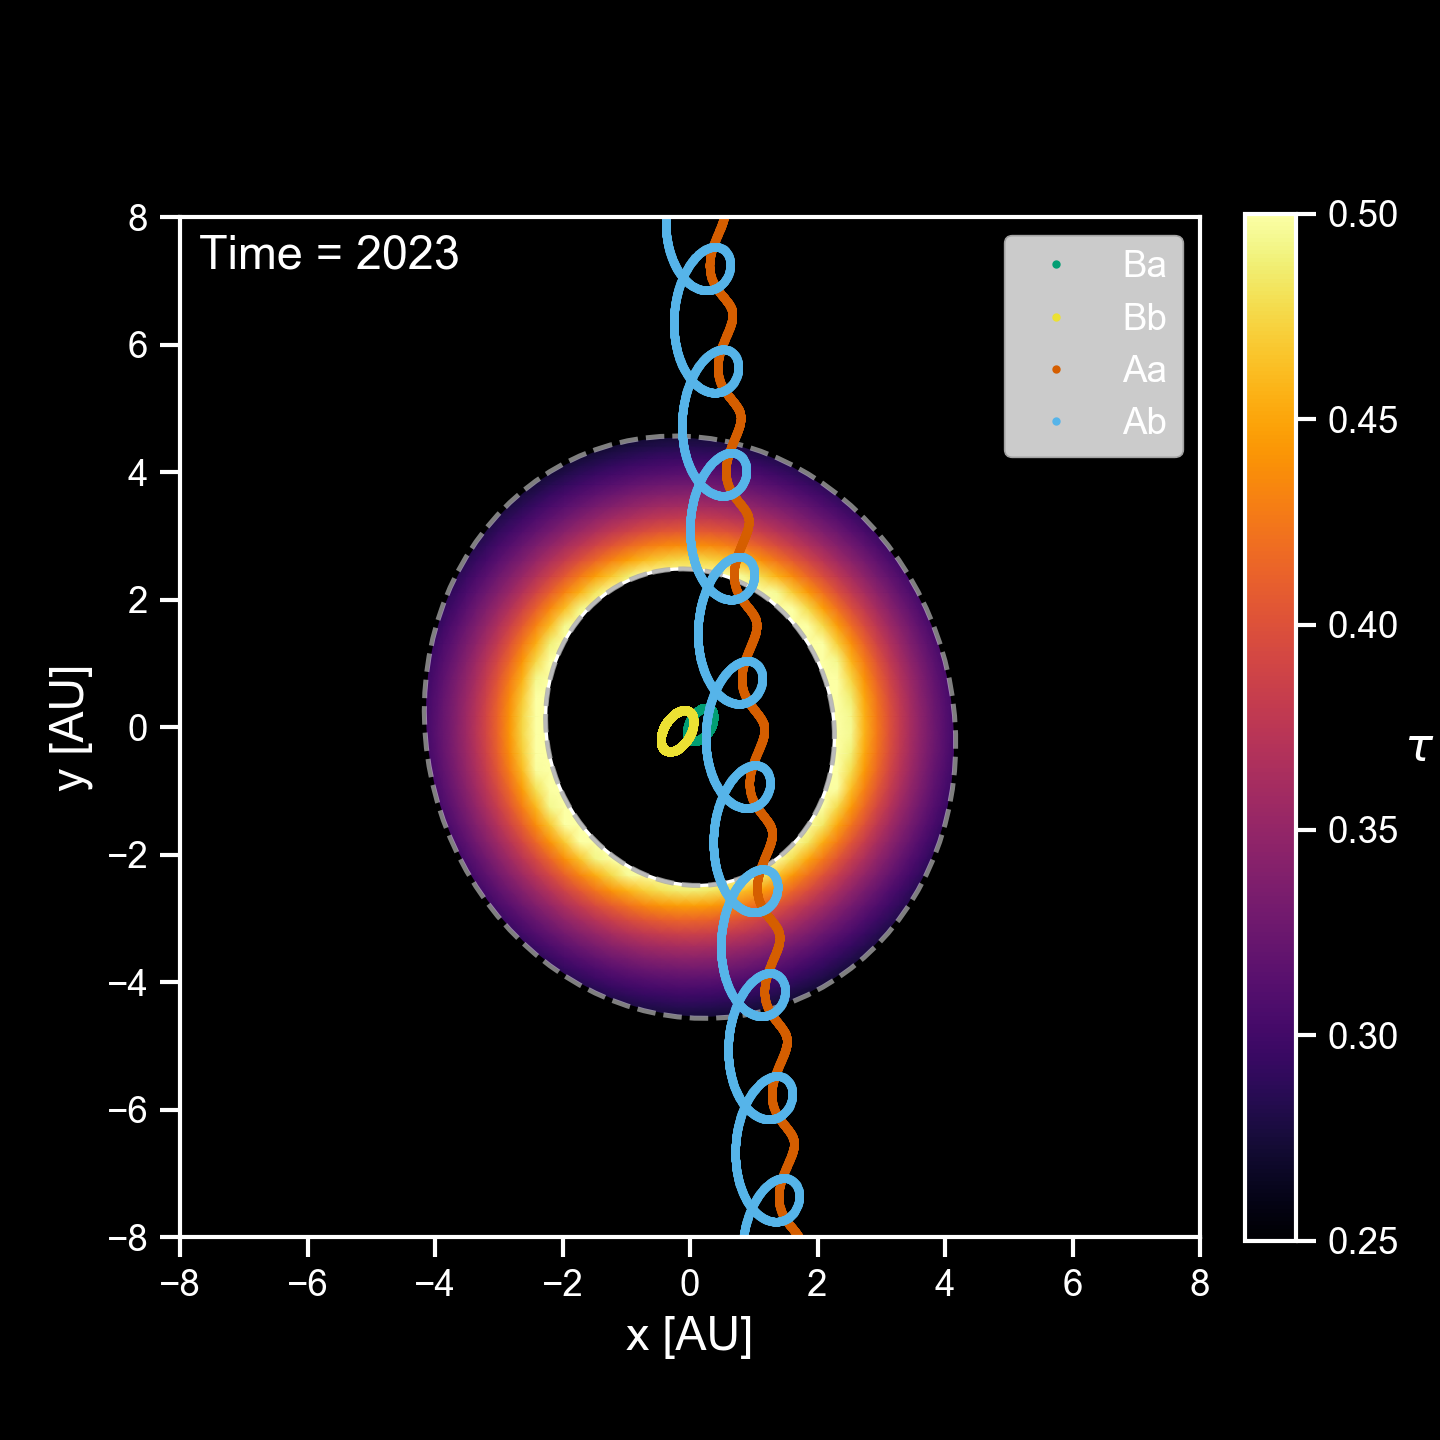

NameError: name 'legend' is not defined

In [24]:
# Build disc
%matplotlib notebook

inner_edge = 2.5
outer_edge = 4.6

x_inner1, y_inner1, z_inner1 = disc_edge(inner_edge)
x_outer1, y_outer1, z_outer1 = disc_edge(outer_edge)

fig,ax = plt.subplots(figsize=(6,6))

plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')

res = 10
xd = np.linspace(x_inner1, x_outer1, res)
yd = np.linspace(y_inner1, y_outer1, res)
X, Y = np.meshgrid(xd,yd)
r0 = inner_edge
R = (X**2 + Y**2)**0.5
taus = 0.5*(r0/R)
# print(X.shape, Y.shape, taus.shape)
# print(taus)

# taus[R > 4.6] = 0
# taus[R < 2.5] = 0

plt.fill(x_inner1,y_inner1, 'black')
fill_disc(outer_edge,20,np.linspace(0, 2*np.pi, 100), ax, colour='black', alpha=1, ec='black')
plt.plot(x_inner1, y_inner1, c='darkgrey', linestyle='dashed', alpha=0.8, figure=fig)
plt.plot(x_outer1, y_outer1, c='white', linestyle='dashed', alpha=0.5, figure=fig)

im = plt.pcolormesh(X, Y, taus, cmap='inferno', vmin=0.25, vmax=0.5, shading='gouraud')
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('$\\tau$', rotation=360, labelpad=6)
ax.set_aspect('equal')

plt.plot(x_Ba, y_Ba, 'g.', alpha = 1, markersize=3, label='Ba', figure=fig)
plt.plot(x_Bb, y_Bb, 'y.', alpha = 1, markersize=3, label='Bb', figure=fig)
plt.plot(x_Aa, y_Aa, 'r.', alpha = 1, markersize=3, label='Aa', figure=fig)
plt.plot(x_Ab, y_Ab, 'c.', alpha = 1, markersize=3, label='Ab', figure=fig)
leg = plt.legend()
leg.get_frame().set_facecolor('white')
year = 2023
plt.text(-7.7, 7.2, f'Time = {year}', c='white')
plt.setp(legend.get_texts(), color='black')





In [13]:
# # THIS TAKES A WHILE TO RUN!!
# # ONLY RUN THIS CELL (AND THE ONE AFTER) IF YOU WANT TO SAVE EACH FRAME OF THE TRANSIT FOR A GIF/MOVIE

# fig_gif = plt.figure(2, figsize=(8,8))
# plt.plot(x_inner1, y_inner1, 'w', alpha=0.5, ls='--', linewidth=2)
# plt.plot(x_outer1, y_outer1, 'w', alpha=0.5, ls='--', linewidth=2)
# plt.xlim(-5,5)
# plt.ylim(-5,5)
# plt.xlabel('x [AU]')
# plt.ylabel('y [AU]')


# for i in range(2100,6500,2):
#     plt.plot(x_Ba[i], y_Ba[i], 'g.', markersize=3, figure=fig_gif)
#     plt.plot(x_Bb[i], y_Bb[i], 'y.', markersize=3, figure=fig_gif)
#     plt.plot(x_Aa[i], y_Aa[i], 'skyblue', marker='.', markersize=3, figure=fig_gif)
#     plt.plot(x_Ab[i], y_Ab[i], 'r.', alpha = 0.5, figure=fig_gif)
    
#     tp1, = plt.plot(x_Ba[i], y_Ba[i], 'darkgreen', marker='*', markersize=8, label='Ba', figure=fig_gif)
#     tp2, = plt.plot(x_Bb[i], y_Bb[i], 'gold', marker='*', markersize=8, label='Bb', figure=fig_gif)
#     tp3, = plt.plot(x_Aa[i], y_Aa[i], 'deepskyblue', marker='*', markersize=8, label='Aa', figure=fig_gif)
#     tp4, = plt.plot(x_Ab[i], y_Ab[i], 'firebrick', marker='*', markersize=8, label='Ab', figure=fig_gif)

#     leg = plt.legend(prop={'size': 16})    
#     plt.tick_params(axis='both', which='major', labelsize=18)

#     frame = leg.get_frame()
#     frame.set_facecolor('black')

#     ax = plt.gca()
#     plt.savefig(f'transit_{i}.png')
#     plt.show()

#     tp1.remove()
#     tp2.remove()
#     tp3.remove()
#     tp4.remove()


In [14]:
# import imageio
# images = []
# for i in range(2000,6000,2):
#     images.append(imageio.imread(f'transit_{i}.png'))
# imageio.mimsave('REBOUNDtransit.gif', images, fps=60)

# # For a movie, run:
# # ffmpeg -framerate 30 -pattern_type glob -i 'transit*.png' -c:v libx264 -pix_fmt yuv420p REBOUNDtransit.mp4

In [15]:
# fig_ph, ax = plt.subplots(1, 2, figsize=(8,8))

# # Ab
# data1 = merge_ev_files(1)
# x1 = np.array(data1['1'])
# y1 = np.array(data1['2'])
# vx1 = np.array(data1['5'])
# vy1 = np.array(data1['6'])

# # Bb
# data2 = merge_ev_files(2)
# x2 = np.array(data2['1'])
# y2 = np.array(data2['2'])
# vx2 = np.array(data2['5'])
# vy2 = np.array(data2['6'])

# # Aa
# data3 = merge_ev_files(3)
# x3 = np.array(data3['1'])
# y3 = np.array(data3['2'])
# vx3 = np.array(data3['5'])
# vy3 = np.array(data3['6'])

# # Ba
# data4 = merge_ev_files(4)
# x4 = np.array(data4['1'])
# y4 = np.array(data4['2'])
# vx4 = np.array(data4['5'])
# vy4 = np.array(data4['6'])


# # Shift everything to CoM of B reference frame
# com_A = (m_Ab*np.array([x1,y1]) + m_Aa*np.array([x3,y3]))/m_A
# com_B = (m_Bb*np.array([x2,y2]) + m_Ba*np.array([x4,y4]))/m_B
# x1, y1 = np.array([x1,y1]) - com_B
# x2, y2 = np.array([x2,y2]) - com_B
# x3, y3 = np.array([x3,y3]) - com_B
# x4, y4 = np.array([x4,y4]) - com_B

# # Make plots for comparison (Phantom vs. REBOUND)

# # Phantom data
# ax[1].set_title('Phantom', fontsize=12)
# ax[1].plot(x3, y3, 'b', alpha = 0.9, markersize=4, label='Aa', figure=fig_ph)
# ax[1].plot(x1, y1, 'r', alpha = 0.9, markersize=4, label='Ab', figure=fig_ph)
# ax[1].plot(x4, y4, 'g', alpha = 0.9, markersize=4, label='Ba', figure=fig_ph)
# ax[1].plot(x2, y2, 'y', alpha = 0.9, markersize=4, label='Bb', figure=fig_ph)
# # ax[1].plot(com_A[0], com_A[1], '--', alpha = 0.9, markersize=4, label='CoM A', figure=fig_ph)

# ax[1].plot(x_inner1, y_inner1, 'k', alpha=0.3)
# ax[1].plot(x_outer1, y_outer1, 'k', alpha=0.3)
# fill_disc(a_inner, a_outer, angles, ax[1], alpha=0.3)

# ax[1].set_xlim(-5,5)
# ax[1].set_ylim(-5,5)
# ax[1].set_xlabel('x [AU]')
# ax[1].set_ylabel('y [AU]')
# ax[1].legend()
# ax[1].set_aspect('equal', 'box')

# # REBOUND data
# ax[0].set_title('REBOUND', fontsize=12)
# ax[0].plot(x_Aa, y_Aa, 'b.', alpha = 0.5, markersize=4, label='Aa', figure=fig_ph)
# ax[0].plot(x_Ab, y_Ab, 'r.', alpha = 0.5, markersize=4, label='Ab', figure=fig_ph)
# ax[0].plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=4, label='Ba', figure=fig_ph)
# ax[0].plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=4, label='Bb', figure=fig_ph)


# ax[0].plot(x_inner1, y_inner1, 'k', alpha=0.3)
# ax[0].plot(x_outer1, y_outer1, 'k', alpha=0.3)
# fill_disc(a_inner, a_outer, angles, ax[0], alpha=0.3)

# ax[0].set_xlim(-5,5)
# ax[0].set_ylim(-5,5)
# ax[0].set_xlabel('x [AU]')
# ax[0].set_ylabel('y [AU]')
# ax[0].legend()
# ax[0].set_aspect('equal', 'box')
# fig_ph.tight_layout()


# fig_ph.tight_layout()


In [16]:
# fig,ax = plt.subplots(figsize=(5,5))
# angles = np.linspace(0, 2*np.pi, 100)


# # M_dist = 0.28 Mearth
# # Ab
# data1 = merge_ev_files(1, wd='./hd98800')
# x1 = np.array(data1['1'])
# y1 = np.array(data1['2'])
# vx1 = np.array(data1['5'])
# vy1 = np.array(data1['6'])

# # Bb
# data2 = merge_ev_files(2, wd='./hd98800')
# x2 = np.array(data2['1'])
# y2 = np.array(data2['2'])
# vx2 = np.array(data2['5'])
# vy2 = np.array(data2['6'])

# # Aa
# data3 = merge_ev_files(3, wd='./hd98800')
# x3 = np.array(data3['1'])
# y3 = np.array(data3['2'])
# vx3 = np.array(data3['5'])
# vy3 = np.array(data3['6'])

# # Ba
# data4 = merge_ev_files(4, wd='./hd98800')
# x4 = np.array(data4['1'])
# y4 = np.array(data4['2'])
# vx4 = np.array(data4['5'])
# vy4 = np.array(data4['6'])


# # Shift everything to CoM of B reference frame
# com_A = (m_Ab*np.array([x1,y1]) + m_Aa*np.array([x3,y3]))/m_A
# com_B = (m_Bb*np.array([x2,y2]) + m_Ba*np.array([x4,y4]))/m_B
# x1_l, y1_l = np.array([x1,y1]) - com_B
# x2_l, y2_l = np.array([x2,y2]) - com_B
# x3_l, y3_l = np.array([x3,y3]) - com_B
# x4_l, y4_l = np.array([x4,y4]) - com_B


# # M_dist = 33 Mearth
# # Ab
# data1 = merge_ev_files(1, wd='./hd98800_30m')
# x1 = np.array(data1['1'])
# y1 = np.array(data1['2'])
# vx1 = np.array(data1['5'])
# vy1 = np.array(data1['6'])

# # Bb
# data2 = merge_ev_files(2, wd='./hd98800_30m')
# x2 = np.array(data2['1'])
# y2 = np.array(data2['2'])
# vx2 = np.array(data2['5'])
# vy2 = np.array(data2['6'])

# # Aa
# data3 = merge_ev_files(3, wd='./hd98800_30m')
# x3 = np.array(data3['1'])
# y3 = np.array(data3['2'])
# vx3 = np.array(data3['5'])
# vy3 = np.array(data3['6'])

# # Ba
# data4 = merge_ev_files(4, wd='./hd98800_30m')
# x4 = np.array(data4['1'])
# y4 = np.array(data4['2'])
# vx4 = np.array(data4['5'])
# vy4 = np.array(data4['6'])


# # Shift everything to CoM of B reference frame
# com_A = (m_Ab*np.array([x1,y1]) + m_Aa*np.array([x3,y3]))/m_A
# com_B = (m_Bb*np.array([x2,y2]) + m_Ba*np.array([x4,y4]))/m_B
# x1_h, y1_h = np.array([x1,y1]) - com_B
# x2_h, y2_h = np.array([x2,y2]) - com_B
# x3_h, y3_h = np.array([x3,y3]) - com_B
# x4_h, y4_h = np.array([x4,y4]) - com_B
# # Make plots for comparison (Phantom vs. REBOUND)

# # Phantom data - low mass
# ax.plot(x3_l, y3_l, c='magenta', alpha = 0.9, markersize=6, label='Aa (low $M_{d}$)')
# ax.plot(x1_l, y1_l, c='cyan', alpha = 0.9, markersize=6, label='Ab (low $M_{d}$)')
# ax.plot(x4_l, y4_l, c='navy', alpha = 0.9, markersize=6, label='Ba (low $M_{d}$)')
# ax.plot(x2_l, y2_l, c='orange', alpha = 0.9, markersize=6, label='Bb (low $M_{d}$)')

# ax.plot(x_inner1, y_inner1, 'k', alpha=0.3)
# ax.plot(x_outer1, y_outer1, 'k', alpha=0.3)
# fill_disc(a_inner, a_outer, angles, ax, alpha=0.3)


# # Phantom data - high mass
# ax.plot(x3_h, y3_h, 'b--', alpha = 0.9, markersize=3, label='Aa (high $M_{d}$)')
# ax.plot(x1_h, y1_h, 'r--', alpha = 0.9, markersize=3, label='Ab (high $M_{d}$)')
# ax.plot(x4_h, y4_h, 'go', alpha = 0.9, markersize=0.5, label='Ba (high $M_{d}$)')
# ax.plot(x2_h, y2_h, 'yo', alpha = 0.9, markersize=0.5, label='Bb (high $M_{d}$)')


# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# ax.set_xlabel('x [AU]')
# ax.set_ylabel('y [AU]')
# ax.set_aspect('equal')
# plt.legend()
# plt.tight_layout()


552


<IPython.core.display.Javascript object>


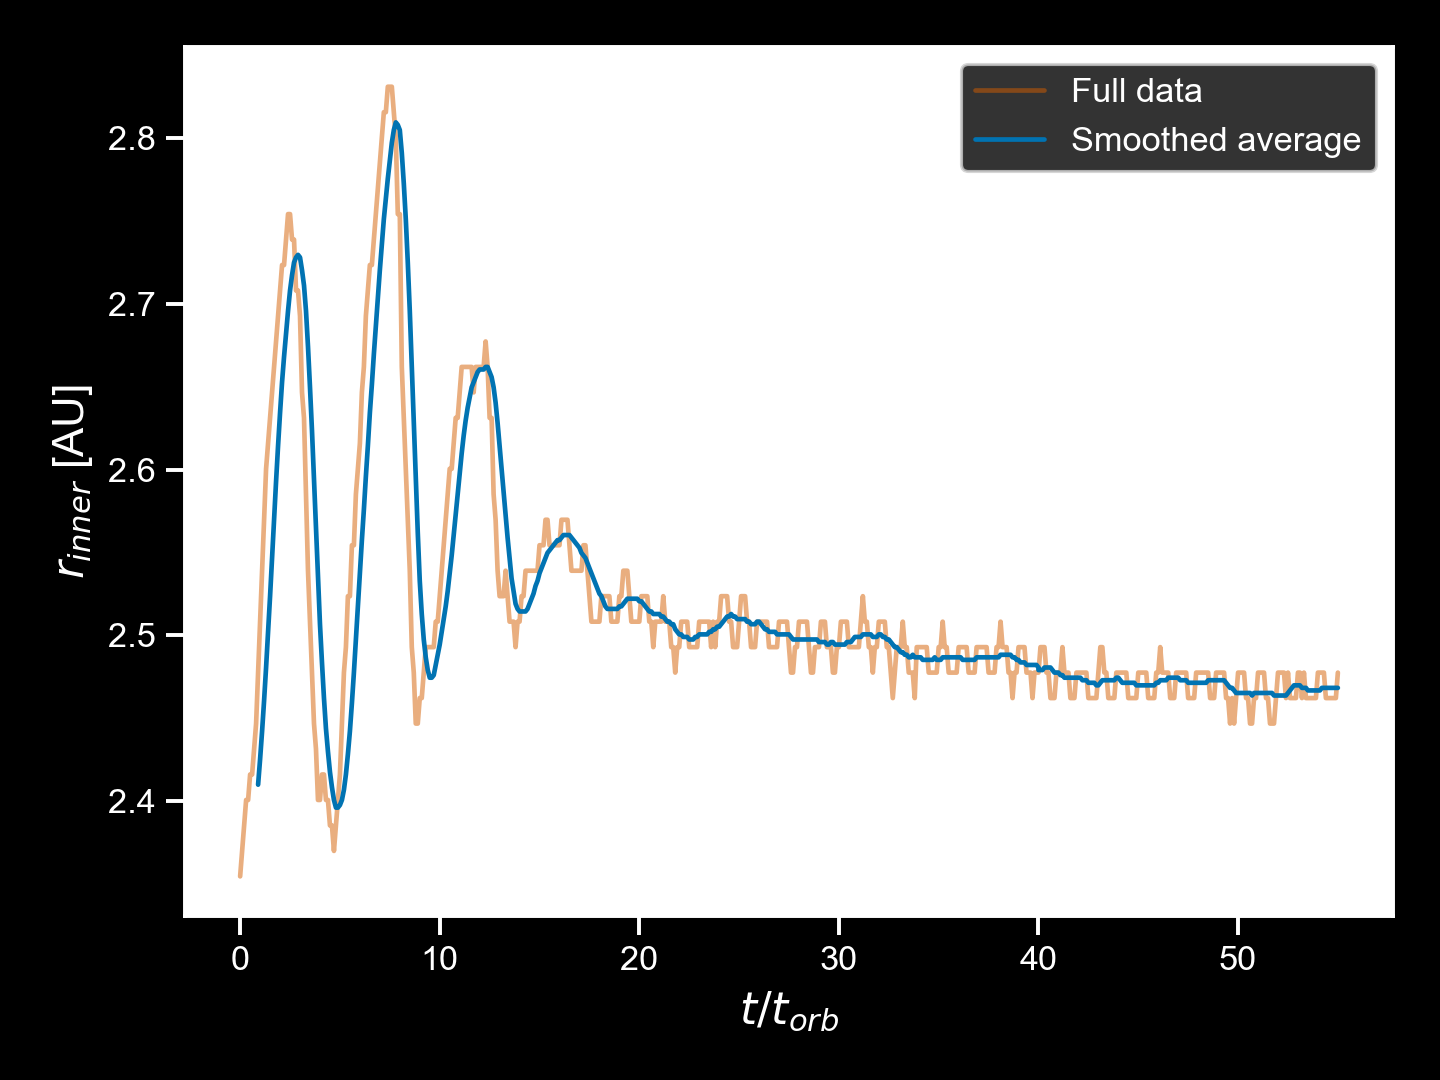

In [16]:
home_dir = "/storage/astro2/phrkvg/"
wd = "hd98800_30m_transit0/"
angm_files = range(0,4001,10)

frac = 0.5

r_inners = []
r_outers = []
times = []
sigma_inners = []

columns = ['radius', 'sigma', '<h>/H', 'lx', 'ly', 'lz', 'tilt', 'twist', 'psi', 'H/R', '|e|']

for angm_file in angm_files:
    file_no = str(angm_file).rjust(5, '0')
    file = home_dir+wd+"angm" + file_no
    time = float(open(file).readline().split()[-1])/(2*np.pi*0.862)    # [Number of B binary orbits]
    data = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)])
    sigma_frac = frac*np.nanmax(data['sigma'])
    max_i = np.nanargmax(data['sigma'])
    inner_edge =  np.nanargmin(data['sigma'][:max_i])
    outer_edge =  np.nanargmin(data['sigma'][max_i:])
    for i in range(max_i):
        if data['sigma'][i] < sigma_frac:
            continue
        else:
            inner_edge = i
            break
    for i in range(max_i,len(data)):
        if data['sigma'][i] > sigma_frac:
            continue
        else:
            outer_edge = i
            break

    r_inner = data['radius'][inner_edge]
    sigma_inner = data['sigma'][inner_edge]
    r_outer = data['radius'][outer_edge]
    sigma_outer = data['sigma'][outer_edge] 


    r_inners.append(r_inner)
    r_outers.append(r_outer)
    times.append(time)    # convert time units to number of B orbits
    sigma_inners.append(sigma_inner)
            
wd = "hd98800_30m_transit/"
angm_files = range(400,1901,10)

for angm_file in angm_files:
    file_no = str(angm_file).rjust(5, '0')
    file = home_dir+wd+"angm" + file_no
    time = float(open(file).readline().split()[-1])/(2*np.pi*0.862)    # [Number of B binary orbits]
    data = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)]) 
    sigma_frac = frac*np.nanmax(data['sigma'])
    max_i = np.nanargmax(data['sigma'])
    inner_edge =  np.nanargmin(data['sigma'][:max_i])
    outer_edge =  np.nanargmin(data['sigma'][max_i:])
    for i in range(max_i):
        if data['sigma'][i] < sigma_frac:
            continue
        else:
            inner_edge = i
            break
    for i in range(max_i,len(data)):
        if data['sigma'][i] > sigma_frac:
            continue
        else:
            outer_edge = i
            break



    r_inner = data['radius'][inner_edge]
    sigma_inner = data['sigma'][inner_edge]
    r_outer = data['radius'][outer_edge]
    sigma_outer = data['sigma'][outer_edge] 


    r_inners.append(r_inner)
    r_outers.append(r_outer)
    times.append(time)    # convert time units to number of B orbits
    sigma_inners.append(sigma_inner)


print(len(r_inners))
fig_rinner = plt.figure()
plt.xlabel('$t/t_{orb}$')
plt.ylabel('$r_{inner}$ [AU]')
radii_binned = pd.DataFrame(r_inners).rolling(10).mean()[0].tolist()
plt.plot(times, r_inners, 'r', alpha=0.5, label='Full data')
plt.plot(times, radii_binned, 'b', label='Smoothed average')
plt.tight_layout()
leg = plt.legend()
frame = leg.get_frame()
frame.set_facecolor('black')
    

In [36]:
# # Add real disc to fig_ph

# fig_ph2, ax = plt.subplots(1, 2, figsize=(8,8))

# angm_files = np.arange(422,482,1)   # angm files included in box range -5 to 5
# columns = ['radius', 'sigma', '<h>/H', 'lx', 'ly', 'lz', 'tilt', 'twist', 'psi', 'H/R', '|e|']
# angles = np.linspace(0, 2*np.pi, 100)

# # r_outers = []

# # for i, angm_file in enumerate(angm_files):
# #     file_no = str(angm_file).rjust(5, '0')
# #     file = "./disc_2_stars_copy/"+"angm" + file_no
# #     data = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)]) 
# #     data = data[(data.sigma != 0)]
# #     r_min = data.radius.iloc[0]
# #     r_outer = data.radius.iloc[-1]
# #     r_inner = radii_binned[i]
# #     r_outers.append(r_outer)

# # # Uncomment to plot all edges on a single plot
# # for row_index, row in data.iterrows():
# #     if row.radius > r_inner:
# #         x_disc, y_disc = disc_edge(row.radius, angles=angles)
# #         ax[1].plot(x_disc, y_disc, 'k', alpha = 0.004, markersize=4, figure=fig_ph2)
# # # ------------------------------------------------

# # # Uncomment to plot all inner and outer disc edges
# # xmin_disc, ymin_disc = disc_edge(r_inner, angles=angles)
# # xmax_disc, ymax_disc = disc_edge(r_outer, angles=angles)
# # ax[1].plot(xmin_disc, ymin_disc, 'yellowgreen', alpha = 0.005, markersize=4, figure=fig_ph2)
# # ax[1].plot(xmax_disc, ymax_disc, 'powderblue', alpha = 0.005, markersize=4, figure=fig_ph2)
# # # ------------------------------------------------



# # ====================== Phantom data =============================

# # Uncomment to plot disc average edges, as well as minimum and maximum
# avg_rinner = np.mean(r_inners)
# min_rinner = min(r_inners)
# max_rinner = max(r_inners)

# avg_router = np.mean(r_outers)
# min_router = min(r_outers)
# max_router= max(r_outers)

# fill_disc(min_router, max_router, angles, ax[1], colour='powderblue', alpha=0.3)
# avg_xouter,  avg_youter = disc_edge(avg_router)[:2]
# ax[1].plot(avg_xouter, avg_youter, 'powderblue', alpha = 0.8, markersize=4, figure=fig_ph2)

# fill_disc(min_rinner, max_rinner, angles, ax[1], colour='yellowgreen', alpha=0.3)
# avg_xinner,  avg_yinner = disc_edge(avg_rinner)[:2]
# ax[1].plot(avg_xinner, avg_yinner, 'yellowgreen', alpha = 0.8, markersize=4, figure=fig_ph2)
# # ---------------------------------------------------------------


# # # Uncomment to plot disc minimum and maximum extents 

# # disc_widths = np.array(r_outers) - np.array(r_inners)
# # disc_minwidth_i = np.nanargmin(disc_widths)
# # disc_maxwidth_i = np.nanargmax(disc_widths)
# # r_inner_min = r_inners[disc_minwidth_i]
# # r_inner_max = r_inners[disc_maxwidth_i]
# # r_outer_min = r_outers[disc_minwidth_i]
# # r_outer_max = r_outers[disc_maxwidth_i]

# # fill_disc(r_inner_max, r_outer_max, angles, ax[1], colour='orange', alpha=0.3)
# # fill_disc(r_inner_min, r_outer_min, angles, ax[1], colour='turquoise', alpha=0.7)


# # xinner_min, yinner_min = disc_edge(r_inner_min, angles=angles)[:2]
# # ax[1].plot(xinner_min, yinner_min, 'turquoise', alpha = 0.2, markersize=4, figure=fig_ph2)
# # xouter_min, youter_min = disc_edge(r_outer_min, angles=angles)[:2]
# # ax[1].plot(xouter_min, youter_min, 'turquoise', alpha = 0.2, markersize=4, figure=fig_ph2)
# # xinner_max, yinner_max = disc_edge(r_inner_max, angles=angles)[:2]
# # ax[1].plot(xinner_max, yinner_max, 'orange', alpha = 0.2, markersize=4, figure=fig_ph2)
# # xouter_max, youter_max = disc_edge(r_outer_max, angles=angles)[:2]
# # ax[1].plot(xouter_max, youter_max, 'orange', alpha = 0.2, markersize=4, figure=fig_ph2)
# # # ---------------------------------------------------------------


# # Plot Aa, Ab, Ba, Bb trajectories
# ax[1].set_title('Phantom', fontsize=12)
# ax[1].plot(x3, y3, 'b', alpha = 0.9, markersize=2, label='Aa', figure=fig_ph2)
# ax[1].plot(x1, y1, 'r', alpha = 0.9, markersize=2, label='Ab', figure=fig_ph2)
# ax[1].plot(x4, y4, 'g', alpha = 0.9, markersize=2, label='Ba', figure=fig_ph2)
# ax[1].plot(x2, y2, 'y', alpha = 0.9, markersize=2, label='Bb', figure=fig_ph2)
# ax[1].plot(com_A[0], com_A[1], '--', alpha = 0.9, markersize=4, label='CoM A', figure=fig_ph2)

# ax[1].set_xlim(-5,5)
# ax[1].set_ylim(-5,5)
# ax[1].set_xlabel('x [AU]')
# ax[1].set_ylabel('y [AU]')
# ax[1].legend(loc='upper right')
# ax[1].set_aspect('equal', 'box')

# # ========================== REBOUND data =============================
# ax[0].set_title('REBOUND', fontsize=12)
# # ax[0].plot(x_inner1, y_inner1, 'k', alpha=0.3)
# # ax[0].plot(x_outer1, y_outer1, 'k', alpha=0.3)
# fill_disc(a_inner, a_outer, angles, ax[0], alpha=0.3)

# ax[0].plot(x_Aa, y_Aa, 'b.', alpha = 0.5, markersize=2, label='Aa', figure=fig_ph2)
# ax[0].plot(x_Ab, y_Ab, 'r.', alpha = 0.5, markersize=2, label='Ab', figure=fig_ph2)
# ax[0].plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=2, label='Ba', figure=fig_ph2)
# ax[0].plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=2, label='Bb', figure=fig_ph2)


# ax[0].set_xlim(-5,5)
# ax[0].set_ylim(-5,5)
# ax[0].set_xlabel('x [AU]')
# ax[0].set_ylabel('y [AU]')
# ax[0].legend(loc='upper right')
# ax[0].set_aspect('equal', 'box')
# fig_ph2.tight_layout()


# fig_ph2.tight_layout()


In [33]:
# home_dir = "/storage/astro2/phrkvg/"
# wd = "hd98800/"
# angm_files = range(1,551,1)

# times = []
# sigma_vars = []

# columns = ['radius', 'sigma', '<h>/H', 'lx', 'ly', 'lz', 'tilt', 'twist', 'psi', 'H/R', '|e|']

# file_no = str(0).rjust(5, '0')
# file = home_dir+wd+"angm" + file_no
# data_prev = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)]) 

# for angm_file in angm_files:
#     file_no = str(angm_file).rjust(5, '0')
#     file = home_dir+wd+"angm" + file_no
#     time = float(open(file).readline().split()[-1])/(2*np.pi*0.862)   
#     data_next = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)])
    
#     matched_radii = list(set(data_prev['radius']).intersection(set(data_next['radius'])))
#     sigmas_next = data_next.loc[data_next['radius'].isin(matched_radii)]['sigma']
#     sigmas_prev = data_prev.loc[data_prev['radius'].isin(matched_radii)]['sigma']
#     sigmas_diff = abs(np.array(sigmas_next) - np.array(sigmas_prev))
#     avg_diff = np.mean(sigmas_diff)
#     sigma_vars.append(avg_diff)
#     times.append(time)
#     data_prev = data_next


# sigma_vars_binned = pd.DataFrame(sigma_vars).rolling(10).mean()[0].tolist()
    
# fig_sigma = plt.figure()
# plt.xlabel('$t/t_{orb}$')
# plt.ylabel('Mean change in $\Sigma (\\times 10^{-11})$')
# plt.plot(times, np.array(sigma_vars)/(1e-11), 'r', label='Full data')
# plt.plot(times, np.array(sigma_vars_binned)/(1e-11), 'b', label='Smoothed average')
# plt.tight_layout()
# plt.tick_params(axis='both', which='major', labelsize=16)

# leg = plt.legend(loc='upper right')
# # # Uncomment lines below for dark bg plots
# # frame = leg.get_frame()
# # frame.set_facecolor('black')


    

In [34]:
# fig_comA = plt.figure()

# # Ab
# data1 = merge_ev_files(1)
# x1 = np.array(data1['1'])
# y1 = np.array(data1['2'])
# vx1 = np.array(data1['5'])
# vy1 = np.array(data1['6'])

# # Bb
# data2 = merge_ev_files(2)
# x2 = np.array(data2['1'])
# y2 = np.array(data2['2'])
# vx2 = np.array(data2['5'])
# vy2 = np.array(data2['6'])

# # Aa
# data3 = merge_ev_files(3)
# x3 = np.array(data3['1'])
# y3 = np.array(data3['2'])
# vx3 = np.array(data3['5'])
# vy3 = np.array(data3['6'])

# # Ba
# data4 = merge_ev_files(4)
# x4 = np.array(data4['1'])
# y4 = np.array(data4['2'])
# vx4 = np.array(data4['5'])
# vy4 = np.array(data4['6'])

# com_A = (m_Ab*np.array([x1,y1]) + m_Aa*np.array([x3,y3]))/m_A
# x1, y1 = np.array([x1,y1]) - com_A
# x2, y2 = np.array([x2,y2]) - com_A
# x3, y3 = np.array([x3,y3]) - com_A
# x4, y4 = np.array([x4,y4]) - com_A

# # x_inner1 = x_inner1 - com_A[0]
# # y_inner1 = y_inner1 - com_A[1]
# # x_outer1 = x_outer1 - com_A[0]
# # y_outer1 = y_outer1 - com_A[1]

# plt.plot(x3, y3, 'b', alpha = 0.9, markersize=4, label='Aa', figure=fig_comA)
# plt.plot(x1, y1, 'r', alpha = 0.9, markersize=4, label='Ab', figure=fig_comA)
# # plt.plot(x_inner1, y_inner1)
# # plt.plot(x_outer1, y_outer1)
# plt.legend()
# plt.xlabel('x [AU]')
# plt.ylabel('y [AU]')




In [35]:
# fig_v = plt.figure()

# vy1_smooth = pd.DataFrame(vy1).rolling(40).mean()[0].tolist()
# vy3_smooth = pd.DataFrame(vy3).rolling(40).mean()[0].tolist()
# plt.plot(range(len(vy1)), vy1, 'b', alpha = 0.2, markersize=4, label='vy_Ab', figure=fig_v)
# plt.plot(range(len(vy3)), vy3,  'r', alpha = 0.2, markersize=4, label='vy_Aa', figure=fig_v)
# plt.plot(range(len(vy1)), vy1_smooth, 'b', alpha = 0.9, markersize=4, label='vy_Ab smoothed', figure=fig_v)
# plt.plot(range(len(vy3)), vy3_smooth, 'r', alpha = 0.9, markersize=4, label='vy_Aa smoothed', figure=fig_v)


# v1 = (vy1**2 + vx1**2)**0.5
# v3 = (vy3**2 + vx3**2)**0.5
# v1_smooth = pd.DataFrame(v1).rolling(40).mean()[0].tolist()
# v3_smooth = pd.DataFrame(v3).rolling(40).mean()[0].tolist()

# # plt.plot(range(len(vy1)), v1, 'b', alpha = 0.3, markersize=4, label='v_Ab', figure=fig_v)
# # plt.plot(range(len(vy3)), v3, 'r', alpha = 0.3, markersize=4, label='v_Aa', figure=fig_v)
# # plt.plot(range(len(vy1)), v1_smooth, 'b', alpha = 0.9, markersize=4, label='v_Ab smoothed', figure=fig_v)
# # plt.plot(range(len(vy3)), v3_smooth, 'r', alpha = 0.9, markersize=4, label='v_Aa smoothed', figure=fig_v)

# plt.xlabel('Timestep')
# plt.ylabel('Velocity')
# plt.legend()



In [3]:
%history -g



 1/1: import pymcfost
 1/2: import pymcfost as pm
 1/3: help(pm)
 2/1:
import pymcfost as pm
from astropy.io import fits
 2/2: help(pm)
 2/3: data = fits.open('./dsic_4_stars/data_th/Temperature.fits.gz')
 2/4: data = fits.open('./disc_4_stars/data_th/Temperature.fits.gz')
 2/5: data
 2/6: data.info()
 2/7: data.header()
 2/8: data.header
 2/9: data[0].header
2/10:
import pymcfost as pm
from astropy.io import fits
2/11:
import pymcfost as pm
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
2/12: help(pm)
2/13: data = fits.open('./disc_4_stars/data_th/Temperature.fits.gz')
2/14: data[1]
2/15: data[0]
2/16: data[0].header
2/17:
plt.style.use(astropy_mpl_style)
image_data = fits.getdata(data, ext=0)
2/18: data[0].shape
2/19:
plt.style.use(astropy_mpl_style)
plt.figure()
plt.imshow(data[0], cmap='gray')
plt.colorbar()
2/20: data[0].data
2/21: data[0].data[5000]
2/22: data[0].data[10000]
2/23: data[0].data[1000]
2/24:
plt.style.

29/2:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy import time
import pandas as pd

%matplotlib notebook
29/3:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = time.Time(2023, format='decimalyear').mjd   # t_ref = T0_AB 

e_B = 0.805
i_B = -np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)+np.pi/2
T0_B = 48707.5
P_B = 314.86
mean_B = (2*np.pi*((t_ref - T0_B)/P_B))%(2*np.pi)

e_A = 0.4808
i_A = -np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)+np.pi/2
T0_A = 48742.5
P_A = 264.51
mean_A = (2*np.pi*((t_ref - T0_A)/P_A))%(2*np.pi)

e_AB = 0.46
i_AB = -np.radians(88.1)
a_AB = 51
m_A = 1.22
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)+np.pi/2
T0_AB = 2023
P_AB = 230
mean_AB = 0


# Disk parame

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



460/31:
# Calculate density from angm and .pix files as stars pass behind disc cavity

home_dir = "/storage/astro2/phrkvg/"
wd = "./hd98800_highdt/"
files = range(421,1701,1)
sigma_limit = 0
cd_limit = 0

sigma_Aa = np.zeros(len(files))
sigma_Ab = np.zeros(len(files))
density_Aa = np.zeros(len(files))
density_Ab = np.zeros(len(files))
times = []

columns = ['radius', 'sigma', '<h>/H', 'lx', 'ly', 'lz', 'tilt', 'twist', 'psi', 'H/R', '|e|']

data1 = merge_ev_files(1, wd=wd, ev_files=2)
data2 = merge_ev_files(2, wd=wd, ev_files=2)
data3 = merge_ev_files(3, wd=wd, ev_files=2)
data4 = merge_ev_files(4, wd=wd, ev_files=2)

for i,file in enumerate(files):
    file_no = str(file).rjust(5, '0')
    file = home_dir+wd+"angm" + file_no
    code_time = float(open(file).readline().split()[-1])
    time = code_time/(2*np.pi)    # [years]
    times.append(time)
    angm_data = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)]) 
    radii = np.array(a